# Need a more intuitive grasp of muscle de-mixing

In particular, it seems like there are some inconsistencies re: matrix dimension in the unmixing model, so I would like to get to the bottom of it.

To best understand how the code should work, want to make a toy version of the de-mixing model here, with only a few basis images, and applying the basic de-mixing:

$$ f = M^{-1}I$$

where:
  * M = model, the set of images of individual muscles, blurred according to PSF
  * f = fits, the time series values for each muscle (what we used to calc \DeltaF/F)
  * I = image, the source image we're trying to fit to

In [35]:
# Imports
import cv2
import numpy as np
import matplotlib.pyplot as plt

## Define basis images

In [36]:
# make a few small matrices with one "on" value
model1 = np.zeros((2,3))
model1[0,2] = 1

model2 = np.zeros((2,3))
model2[1,1] = 1

models = [model1, model2]

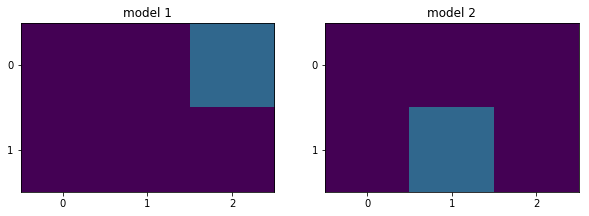

In [37]:
# look at model images
fig, ax_list = plt.subplots(1, len(models),figsize=(10,5))
ax_list = ax_list.ravel()

for ith, model in enumerate(models):
    ax_list[ith].imshow(model, interpolation='none', vmin=0, vmax=3)
    
    ax_list[ith].set_xticks(np.arange(model.shape[1]))
    ax_list[ith].set_yticks(np.arange(model.shape[0]))
    
    ax_list[ith].set_title('model %d'%(ith+1))

## Define the image that we want to fit to

Keeping it very basic

In [73]:
# just make image a simple linear combination of models -- no noise
b_vals = [2, 3]
image = b_vals[0]*models[0] + b_vals[1]*models[1]


Text(0.5,1,'image to fit')

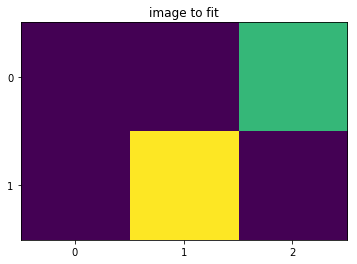

In [74]:
# look at image to fit
fig, ax = plt.subplots()

ax.imshow(image, interpolation='none', vmin=0, vmax=3)

ax.set_xticks(np.arange(image.shape[1]))
ax.set_yticks(np.arange(image.shape[0]))

ax.set_title('image to fit')

## Little helper function(s)

In [131]:
def do_fit_test(model_mat, image_vec):
    """ code to run and visualize fit operation """
    # get matrix pseudo inverse
    model_inv = np.linalg.pinv(model_mat)
    
    # do fit 
    fits = np.dot(model_inv.T, image_vec)
    
    # visualize operation
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,7))

    ax1.imshow(model_inv, interpolation='none')
    ax1.set_xticks(np.arange(model_inv.shape[1]))
    ax1.set_yticks(np.arange(model_inv.shape[0]))
    ax1.set_title('model matrix inverse')

    ax2.imshow(image_vec, interpolation='none')
    ax2.set_xticks(np.arange(image_vec.shape[1]))
    ax2.set_yticks(np.arange(image_vec.shape[0]))
    ax2.set_title('image vector')
    
    ax3.imshow(fits, interpolation='none', vmin=0)
    ax3.set_xticks(np.arange(fits.shape[1]))
    ax3.set_yticks(np.arange(fits.shape[0]))
    ax3.set_title('fits')
    
    # print and return
    print('fits = ', fits)
    
    return fits

## Do the fitting as coded in viewer.py

In [98]:
# Ravel image/models:

# make models into (n x (N*M)) matrix
model_mat = np.vstack([m.T.ravel() for m in models])

# also convert image to vector
image_vec = image.reshape((-1, np.prod(image.shape)))


In [99]:
print('Model mat shape: ', model_mat.shape)
print('Image vector shape: ', image_vec.shape)

('Model mat shape: ', (2, 6))
('Image vector shape: ', (1, 6))


('fits = ', array([[3.],
       [0.]]))


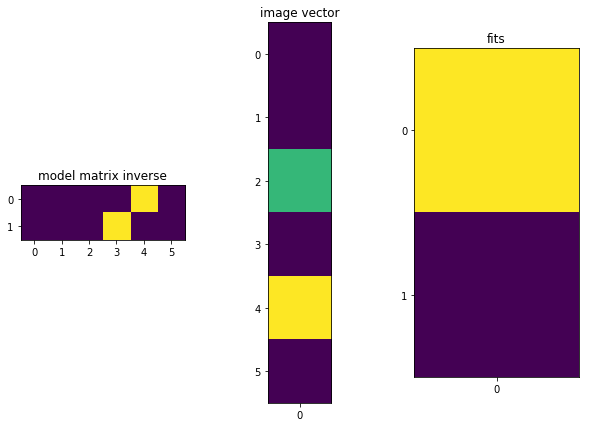

In [101]:
fits = do_fit_test(model_mat.T, image_vec.T)

## Try the thing that makes the most sense to me

In [113]:
# just get the model mat as normally as possible
model_mat = np.vstack([m.ravel() for m in models])
image_vec = image.reshape((np.prod(image.shape), -1))


In [114]:
print('Model mat shape: ', model_mat.shape)
print('Image vector shape: ', image_vec.shape)

('Model mat shape: ', (2, 6))
('Image vector shape: ', (6, 1))


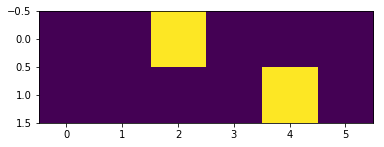

In [116]:
fig, ax = plt.subplots()
ax.imshow(model_mat)

('fits = ', array([[2.],
       [3.]]))


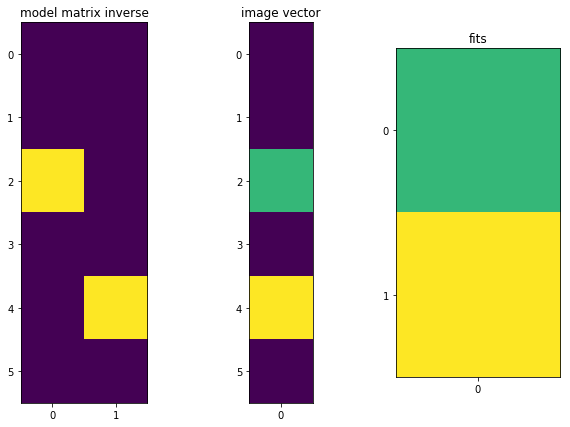

In [115]:
fits = do_fit_test(model_mat, image_vec)

## Method immediately above seems to work -- does it extend to multiple images?

(2, 2, 3)


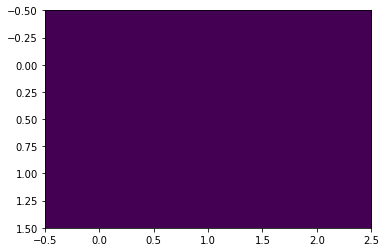

In [121]:
# append another image
image2 = 5*models[1]
image_stack = np.concatenate((image[np.newaxis,:], image2[np.newaxis,:]), axis=0)
 # np.moveaxis( , [0, 1, 2], [1,2,0])
print(image_stack.shape)


In [136]:
#now try the same transformations as above
model_mat = np.vstack([m.ravel() for m in models])
image_vec = image_stack.reshape(-1, (np.prod(image_stack.shape[1:]))).T

('fits = ', array([[2., 0.],
       [3., 5.]]))


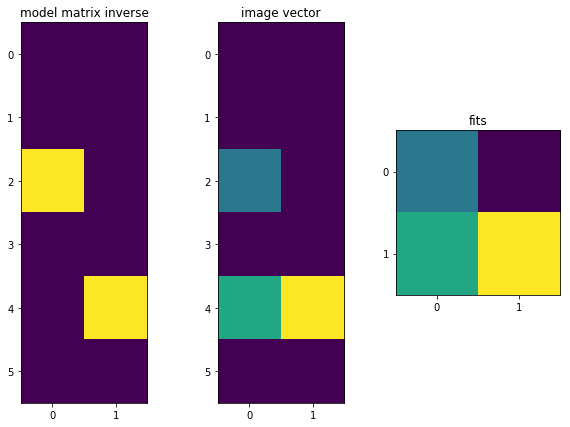

In [137]:
fits = do_fit_test(model_mat, image_vec)

# Okay so what did we learn?

In my current version of the code (as of 3/28/2023) there seems to be some mismatch between the way that the raw data images and the transformed confocal images look (at the very least, there seems to be an up/down flip that I don't know the origin of)

**However** if we get the model images and data images so that they're in the same orientation, we should use the following transformations:

  * `M = np.vstack([muscle.ravel() for muscle in model_muscles])` i.e. get muscle model image just gets flattened out into a row vector, and these get stacked on top of each other (so we'll have a K x (NxM) matrix, where K is the number of model elements)
  * `Imat = I.reshape(-1, (np.prod(I.shape))).T` i.e. take the images we want to fit, and convert each image into a row vector, stack them on top of each other, and then take the transpose (so we'll end up with a (NxM) x T matrix)
  * `Minv = np.linalg.pinv(M).T` take the pseudo-inverse of the model matrix, then take the transpose of this, so we can multiply it by our flattened image matrix (we get back to a K x (NxM) matrix this way)
  * `fits = np.dot(Minv, Imat)` just multiply our two elements